In [1]:
from typing import Callable, Tuple
from IPython.core.display_functions import display
from scipy import rand
from sklearn.datasets import make_classification, make_moons, make_blobs, make_circles, make_s_curve
import numpy as np
import seaborn as sns
from numpy import ndarray
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score, f1_score, balanced_accuracy_score
from time import time_ns, time
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
from scipy.optimize import minimize, LinearConstraint, Bounds, BFGS
plt.rcParams["figure.figsize"] = (20,10)
ZERO = 1e-5
random_state = 244827
n_samples = 2427
n_trains = 1

In [2]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])

        self.y_test = np.reshape(self.y_test, (-1, 1))
        self.y_train = np.reshape(self.y_train, (-1, 1))

        self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.035, random_state=random_state)

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.small_x_train[:, i] = (self.small_x_train[:, i] - x_min) / (x_max - x_min)
                self.small_x_train[:, i] = self.small_x_train[:, i] * (max_v - min_v) + min_v

                self.big_x_train[:, i] = (self.big_x_train[:, i] - x_min) / (x_max - x_min)
                self.big_x_train[:, i] = self.big_x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1
                self.small_x_train[:, i] = 1
                self.big_x_train[:, i] = 1

    def change_labels(self, old: list, new: list):
        for o, n in zip(old, new):
            self.y_test[self.y_test == o] = n
            self.y_train[self.y_train == o] = n
            self.big_y_train[self.big_y_train == o] = n
            self.small_y_train[self.small_y_train == o] = n

    def winsorize(self):
        for i in range(self.x_train.shape[1]):
            if len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)

    def make_fuzzy(self):
        train_fuzz = np.array([(np.sin(np.radians(i)) + 1) / 2 for i in range(self.y_train.shape[0])]).reshape(self.y_train.shape)
        small_fuzz = np.array([(np.sin(np.radians(i)) + 1) / 2 for i in range(self.small_y_train.shape[0])]).reshape(self.small_y_train.shape)
        # train_fuzz = np.array([(np.sin(np.radians(i)) + 1) / 2] for i in range(self.y_train.shape[0]))

        self.y_train_fuzz = np.c_[self.y_train, train_fuzz]
        self.small_fuzz_y_train = np.c_[self.small_y_train, small_fuzz]


In [3]:
class MyFuzzySVM:
    _sparse_kernels = ['linear', 'poly', 'rbf']

    @staticmethod
    def _linear_kernel(x1, x2, *args):
        return np.dot(x1, x2)

    @staticmethod
    def _poly_kernel(x1, x2, *args): # args[0] - degree, args[1] - gamma, args[2] - intercept
        return (args[1] * np.dot(x1, x2) + 1) ** args[0]

    @staticmethod
    def _rbf_kernel(x1, x2, *args):  # args[0] - degree, args[1] - gamma, args[2] - intercept
        return np.exp(-args[1] * np.linalg.norm(x1 - x2) ** 2)

    def __init__(self, C=1, kernel='rbf', gamma=0.1, degree=2, random_state=244827):
        if kernel not in self._sparse_kernels:
            raise ValueError(f'kernel {kernel} is not supported')
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.random_state = random_state
        self.kernel_function = {'linear': self._linear_kernel, 'poly': self._poly_kernel, 'rbf': self._rbf_kernel}[kernel]
        self.coef_ = None
        self.intercept_ = None
        self.alpha_ = None
        self.support_ = None
        self.support_vectors_ = None
        self.support_labels = None
        self.train_labels = None
        self.train_vectors_ = None
        self.train_fuzz_labels = None

    def _lagrange_function(self, alpha):
        res = 0
        x = self.train_vectors_
        y = self.train_labels
        for i in range(alpha.shape[0]):
            for j in range(alpha.shape[0]):
                res += alpha[i] * alpha[j] * y[i] * y[j] * self.kernel_function(x[i], x[j], self.degree, self.gamma, 1)
        return  0.5 * res - np.sum(alpha)

    def fit(self, x_train, y_train):
        self.train_vectors_ = x_train
        self.train_labels = y_train[:, 0]
        self.train_fuzz_labels = y_train[:, 1]
        n, m = x_train.shape
        alpha_start = np.random.uniform(0, self.C, size=n)
        linear_constraint = LinearConstraint(A=self.train_labels, lb=[0], ub=[0])
        bounds = Bounds(
            np.zeros(n),
            np.full(n, self.C * self.train_fuzz_labels)
        )
        result = minimize(
            fun=self._lagrange_function,
            x0=alpha_start,
            # args=(x_train, y_train),
            constraints=[linear_constraint],
            bounds=bounds)
        self.alpha_ = result.x
        self.alpha_[self.alpha_ < ZERO] = 0
        self.support_ = np.where(self.alpha_ > ZERO)[0]
        self.support_vectors_ = x_train[self.support_]
        self.support_labels = y_train[self.support_]

        self.coef_ = np.zeros(m)
        for i in self.support_:
            self.coef_ += np.dot(self.alpha_[i] * self.train_labels[i], x_train[i])

        self.intercept_ = 0
        for i in self.support_:
            self.intercept_ += self.train_labels[i] - np.dot(self.coef_, x_train[i])
        self.intercept_ /= len(self.support_)
        return self

    def decision_function(self, x):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')

        y_pred = []
        for sample in x:
            pred = self.intercept_
            for i in self.support_:
                pred += self.alpha_[i] * self.train_labels[i] * self.kernel_function(self.train_vectors_[i], sample, self.degree, self.gamma, self.intercept_)
            y_pred.append(pred)

        return np.array(y_pred)

    def predict(self, x):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')
        return np.sign(self.decision_function(x))

In [4]:
data_linear = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state), random_state=random_state)
data_linear.change_labels([0], [-1])
data_linear.make_fuzzy()

data_moons = PUMData(make_moons(n_samples=n_samples, noise=0.1, random_state=random_state), random_state=random_state)
data_moons.change_labels([0], [-1])
data_moons.make_fuzzy()

In [5]:
def compare_models(my_model, sk_model, data: PUMData):
    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]

    Z_an = my_model.decision_function(mesh_data).reshape(xx.shape)
    Z_sk = sk_model.decision_function(mesh_data).reshape(xx.shape)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(20, 15))

    for idx, Z, title, model in zip(
        range(2),
        [Z_an, Z_sk],
        ['Implementacja własna', 'Model SVC'],
        [my_model, sk_model]):
        axarr[idx].pcolormesh(xx, yy, np.sign(Z), cmap=plt.cm.Paired, alpha=0.1)
        axarr[idx].contour(xx, yy, Z, linestyles=["--", "-", "--"], levels=[-1, 0, 1])
        axarr[idx].scatter(data.small_x_train[:, 0], data.small_x_train[:, 1], c=data.small_y_train, s=20, edgecolor="k")
        axarr[idx].scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=80, facecolors='none', zorder=10, edgecolors='r')
        axarr[idx].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")
        axarr[idx].set_title(title)

    plt.show()

    y_an_predicted = my_model.predict(data.x_test)
    y_sk_predicted = sk_model.predict(data.x_test)

    cm_sk = confusion_matrix(data.y_test, y_sk_predicted, labels=[-1, 1])
    cm_an = confusion_matrix(data.y_test, y_an_predicted, labels=[-1, 1])

    sensitivity_sk = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])
    specifity_sk = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])

    sensitivity_an = cm_an[1, 1] / (cm_an[1, 0] + cm_an[1, 1])
    specifity_an = cm_an[0, 0] / (cm_an[0, 0] + cm_an[0, 1])

    print(f'Model własny: Czulość: {sensitivity_an}, swoistość: {specifity_an}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_an_predicted, adjusted=True)}')
    print(f'Model sklearn: Czulość: {sensitivity_sk}, swoistość: {specifity_sk}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_sk_predicted, adjusted=True)}')

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model SVC']
    ):
        sns.heatmap(cm, annot=True, fmt="d", ax=axarr[idx], cmap="Blues")
        axarr[idx].set_title(title)

    plt.show()

    my_function = my_model.decision_function(data.x_test)
    sk_function = sk_model.decision_function(data.x_test)

    fpr, tpr, thresholds = roc_curve(data.y_test, my_function)
    plt.plot(fpr, tpr, label=f'my model, AUC={roc_auc_score(data.y_test, my_function):.3f}')
    fpr, tpr, thresholds = roc_curve(data.y_test, sk_function)
    plt.plot(fpr, tpr, label=f'sklearn model, AUC={roc_auc_score(data.y_test, sk_function):.3f}')
    plt.legend()
    plt.show()

In [6]:
start = time()
my_model = MyFuzzySVM(C=1, kernel='linear', gamma=0.1, degree=1)
my_model.fit(data_linear.small_x_train, data_linear.small_fuzz_y_train)
print(f'Training time: {(time() - start)}s')

C:\Users\DonChaka\.conda\envs\py39\lib\site-packages\scipy\optimize\_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Training time: 8.638506412506104s


In [7]:
start = time()
sk_model = SVC(C=1, kernel='linear', gamma=0.1, degree=1, random_state=random_state)
sk_model.fit(data_linear.small_x_train, data_linear.small_y_train)
print(f'Training time: {(time() - start)}s')

Training time: 0.0015041828155517578s


C:\Users\DonChaka\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


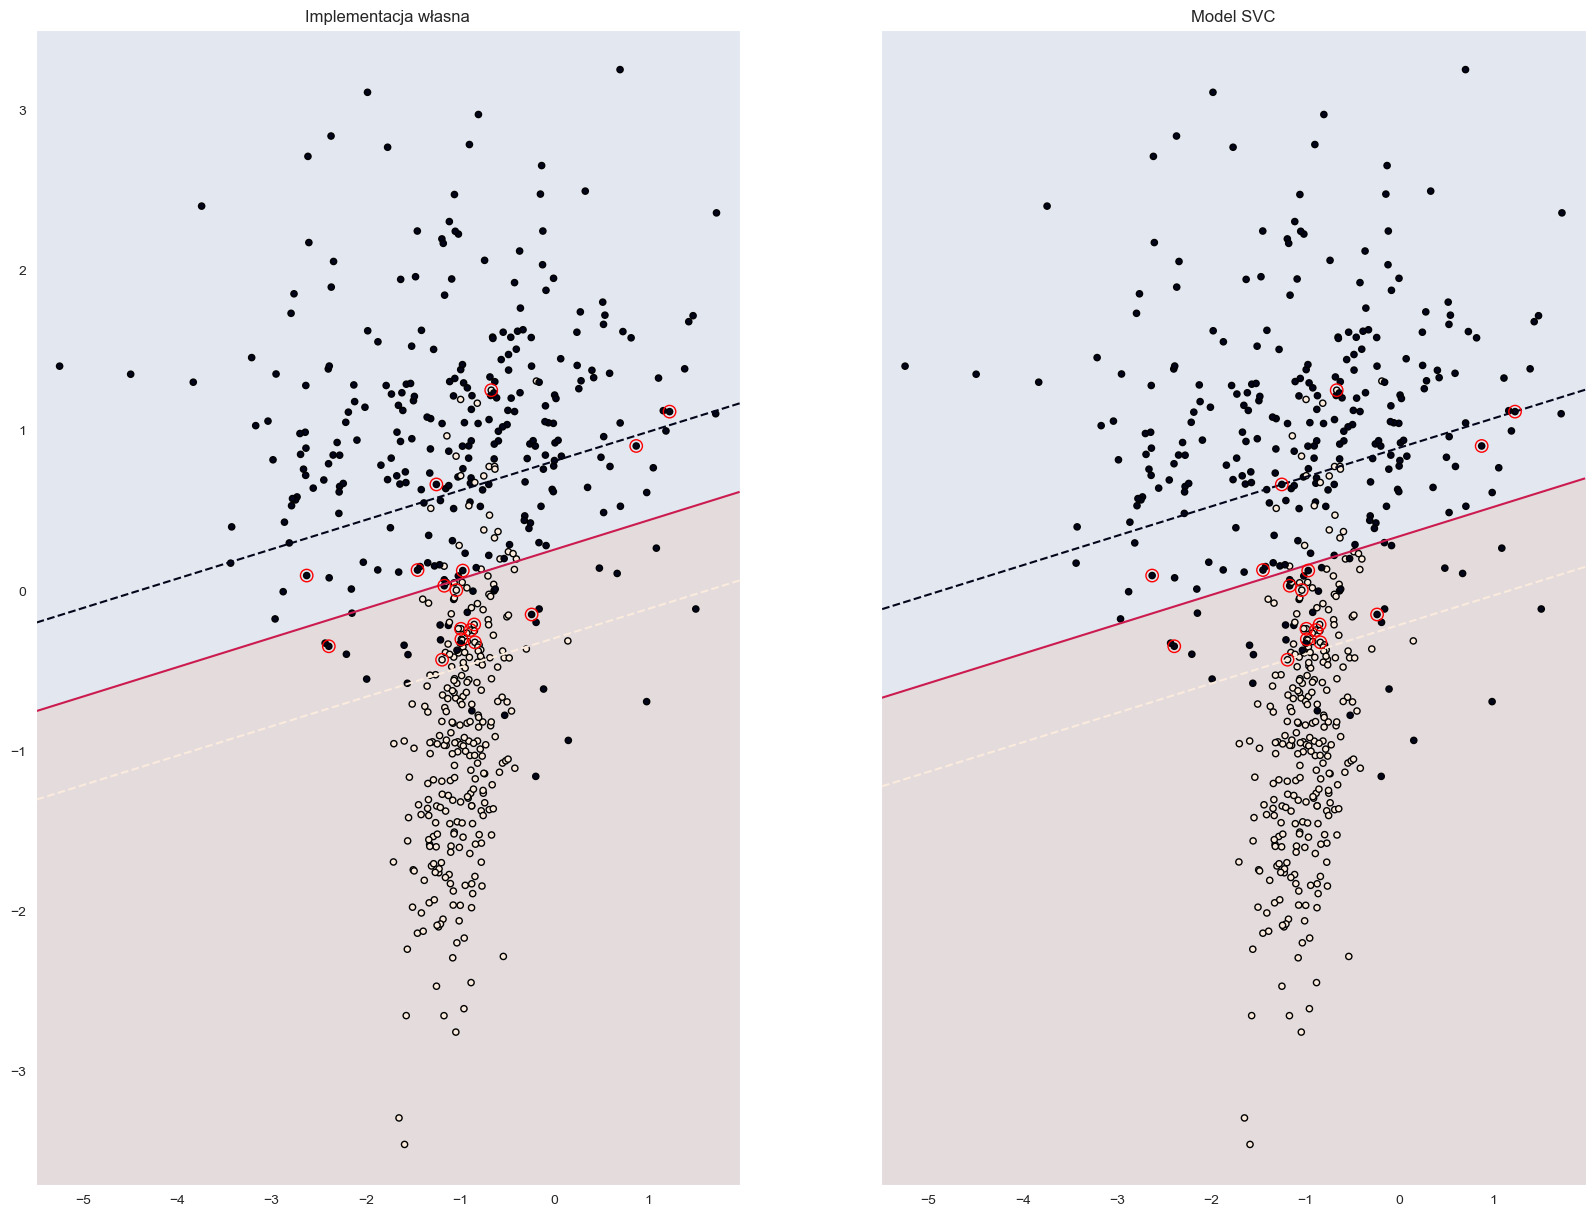

Model własny: Czulość: 0.8975409836065574, swoistość: 0.8801652892561983, Adjusted accuracy=0.7777062728627557
Model sklearn: Czulość: 0.9221311475409836, swoistość: 0.8553719008264463, Adjusted accuracy=0.7775030483674299


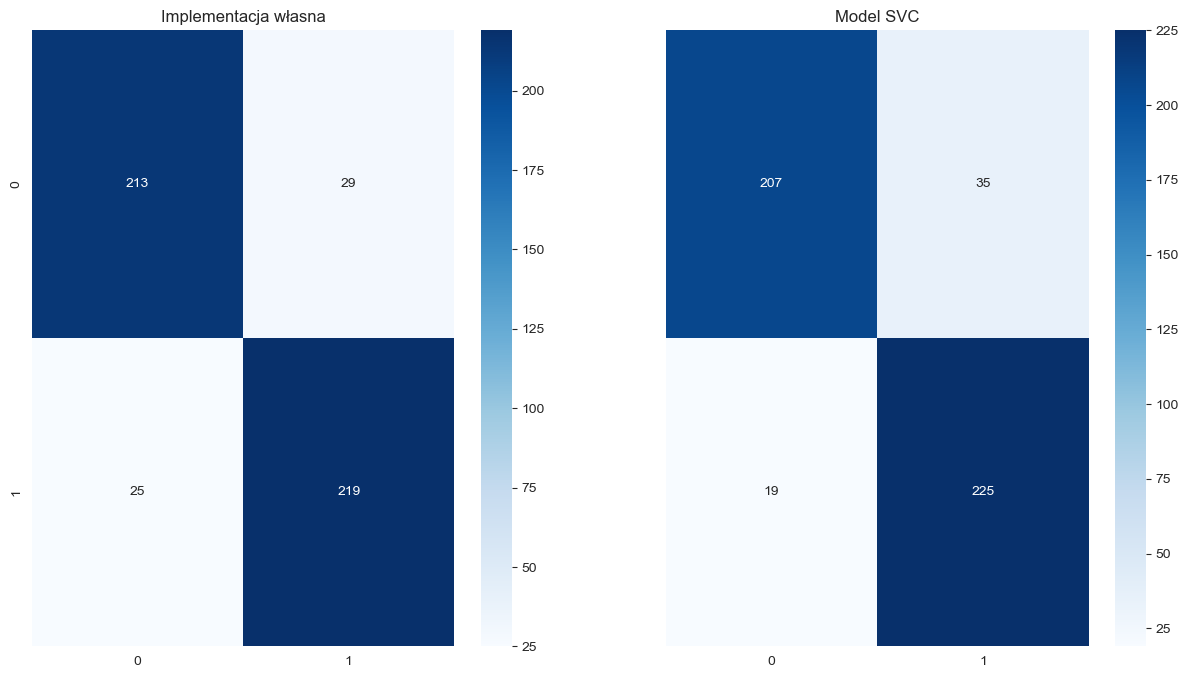

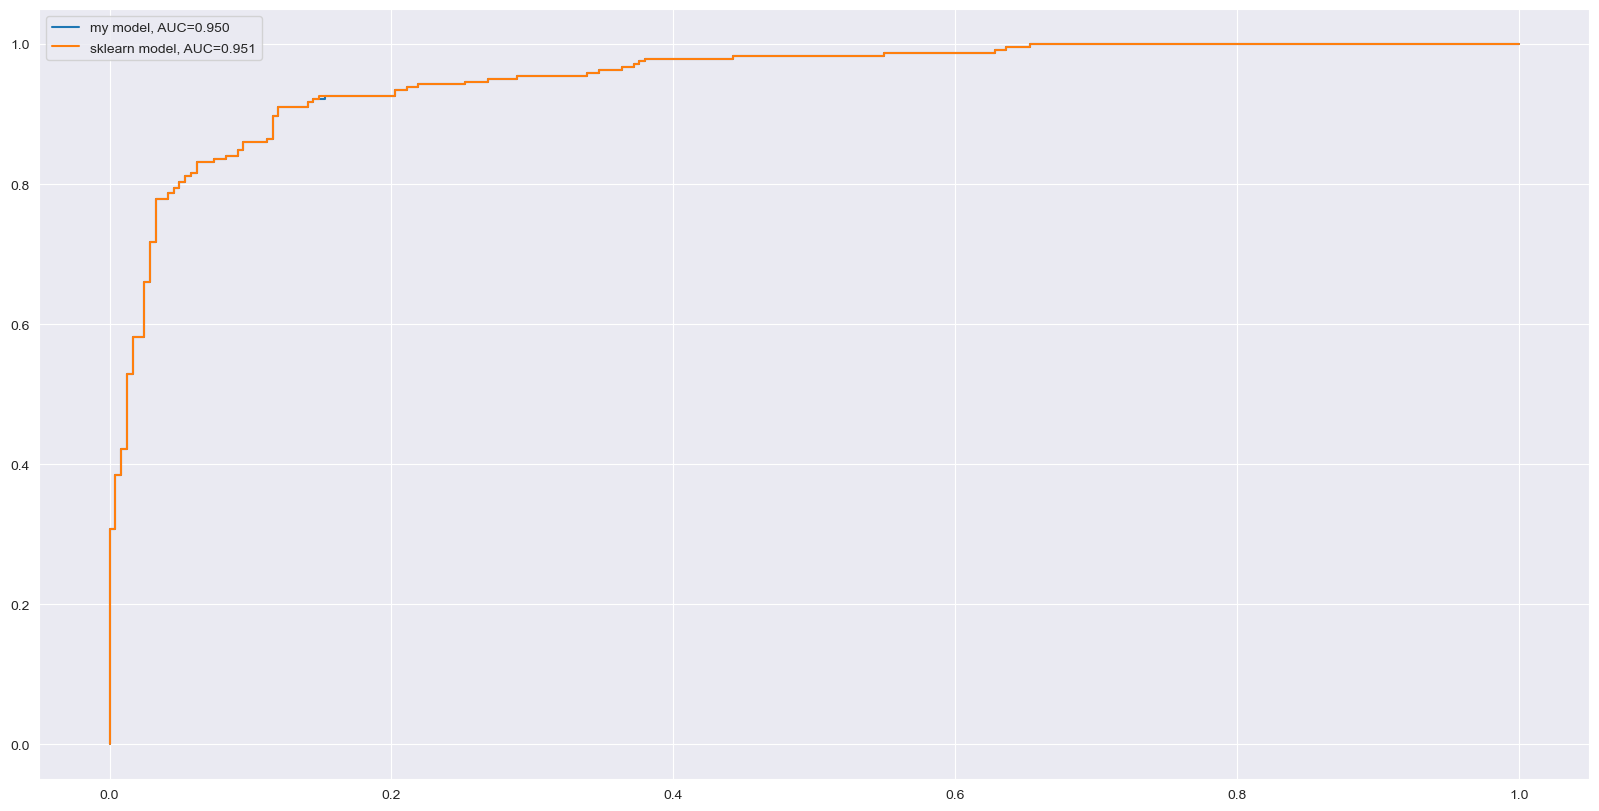

In [8]:
compare_models(my_model, sk_model, data_linear)

In [9]:
start = time()
for _ in range(n_trains):
    my_model_linear_moons = MyFuzzySVM(C=1, kernel='linear', gamma=0.1, degree=1)
    my_model_linear_moons.fit(data_moons.small_x_train, data_moons.small_fuzz_y_train)
print(f'Average training time: {(time() - start) / n_trains}s')

Average training time: 11.891019105911255s


In [10]:
start = time()
for _ in range(n_trains):
    sk_model_linear_moons = SVC(C=1, kernel='linear', gamma=0.1, degree=1, random_state=random_state)
    sk_model_linear_moons.fit(data_moons.small_x_train, data_moons.small_y_train)
print(f'Average training time: {(time() - start) / n_trains}s')

Average training time: 0.0014922618865966797s


C:\Users\DonChaka\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


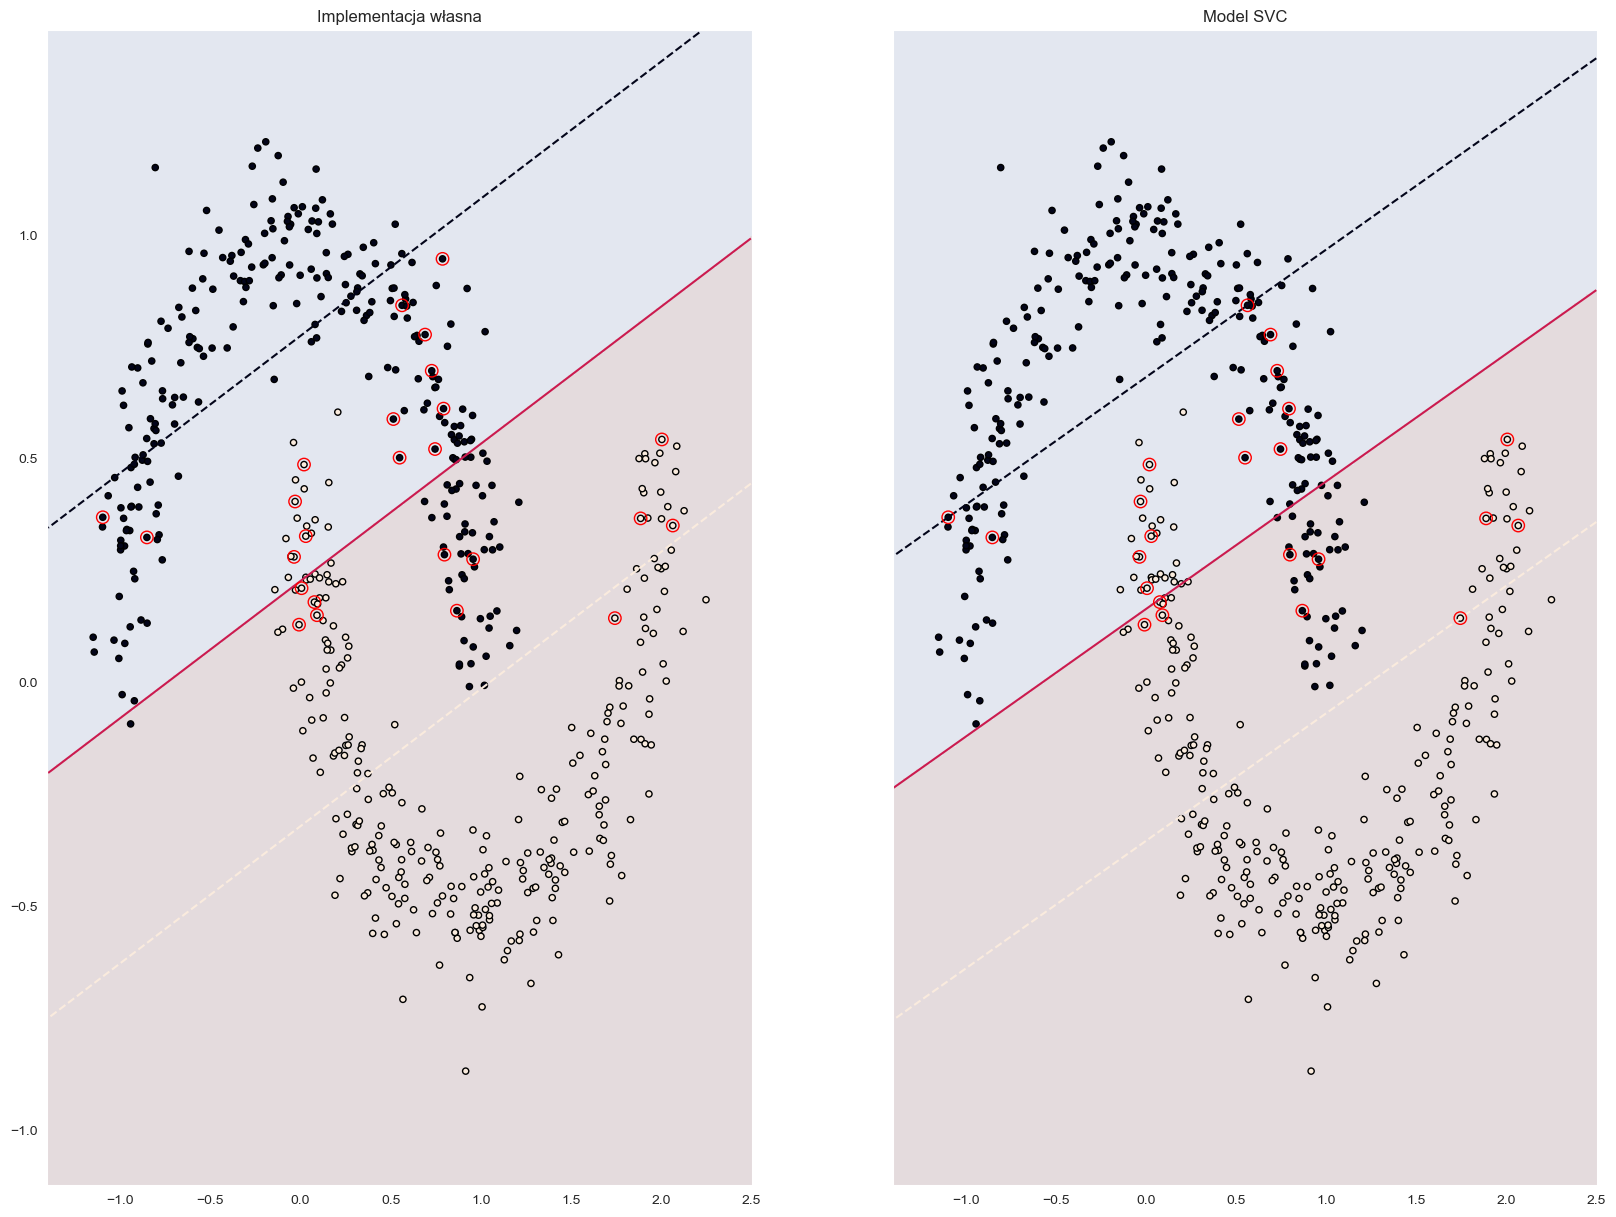

Model własny: Czulość: 0.9423868312757202, swoistość: 0.7983539094650206, Adjusted accuracy=0.7407407407407409
Model sklearn: Czulość: 0.9012345679012346, swoistość: 0.8436213991769548, Adjusted accuracy=0.7448559670781894


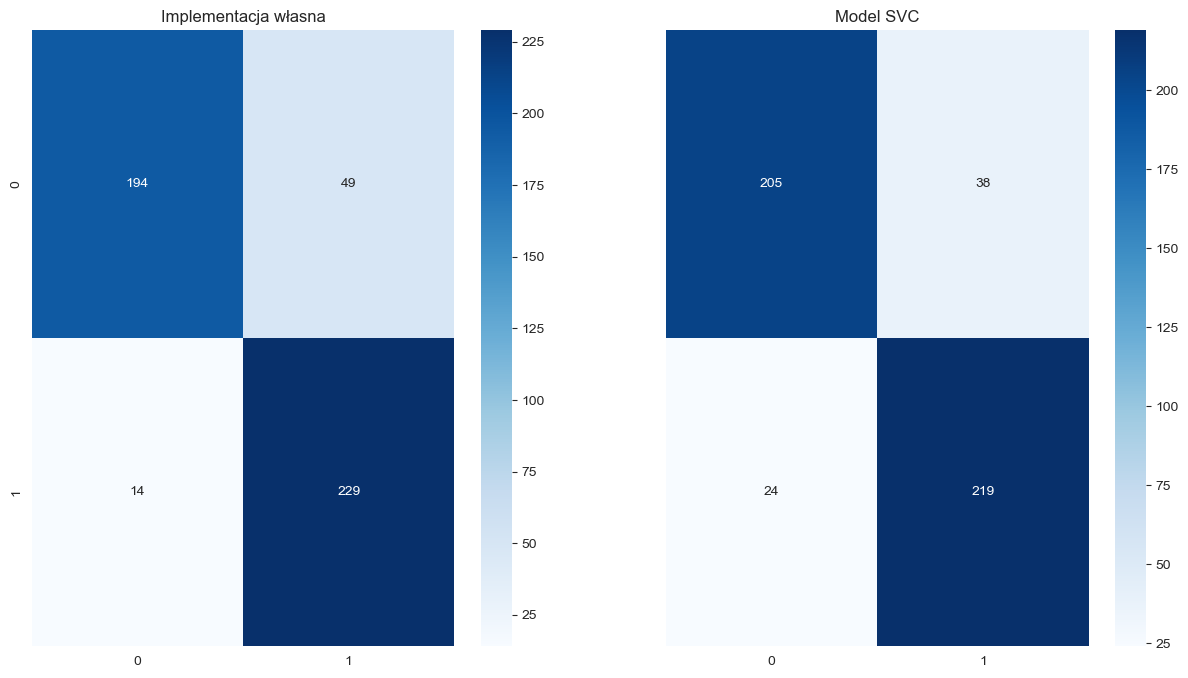

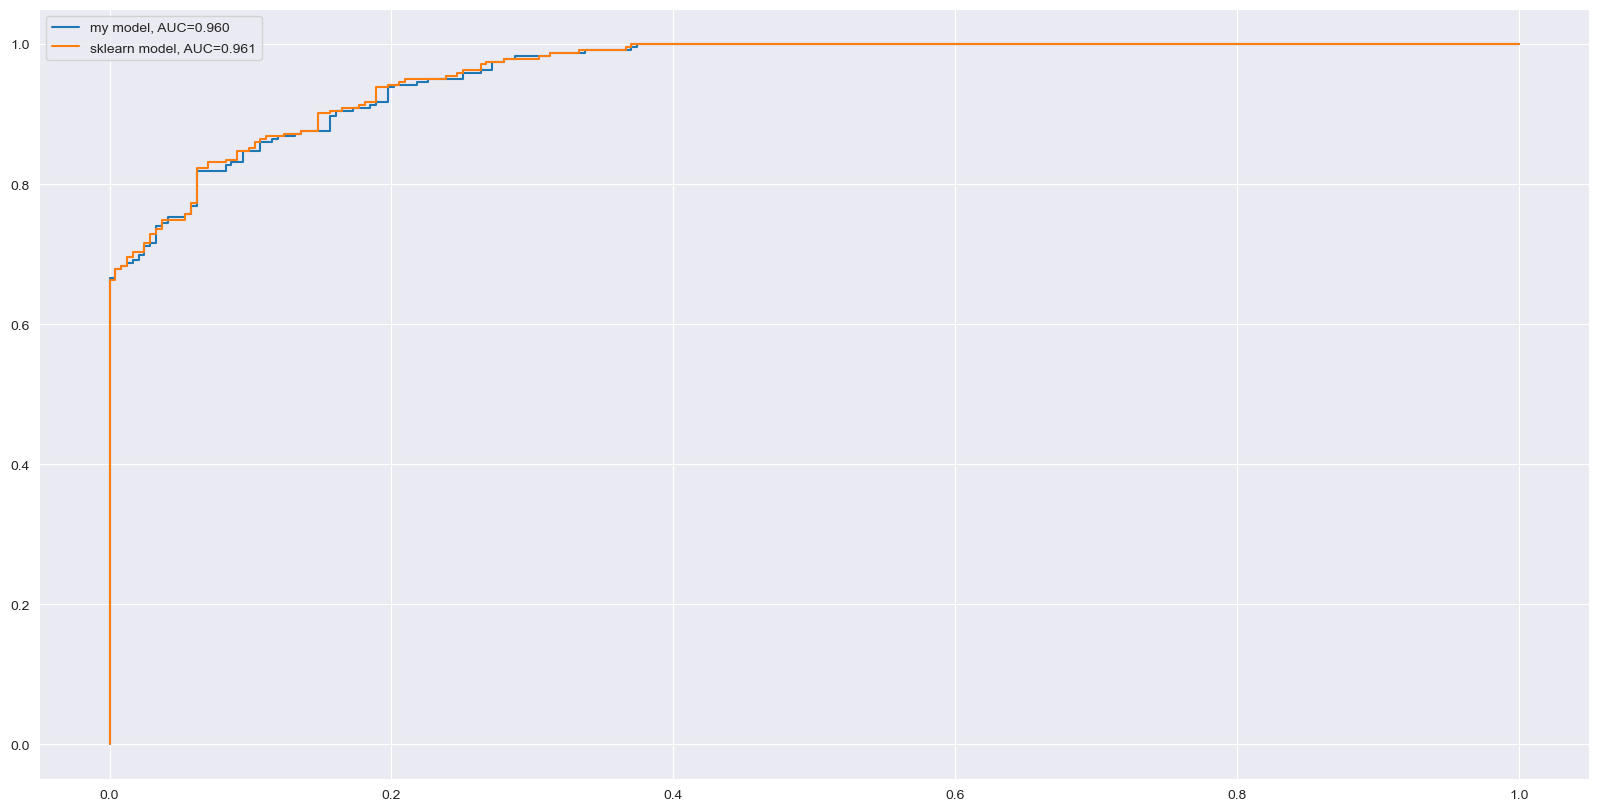

In [11]:
compare_models(my_model_linear_moons, sk_model_linear_moons, data_moons)

In [12]:
start = time()
for _ in range(n_trains):
    my_model_poly = MyFuzzySVM(C=1, kernel='poly', degree=3, gamma=0.5)
    my_model_poly.fit(data_moons.small_x_train, data_moons.small_fuzz_y_train)
print(f'Average training time: {(time() - start)/n_trains}s')

Average training time: 16.89450764656067s


In [13]:
start = time()
for _ in range(n_trains):
    sk_model_poly = SVC(C=1, kernel='poly', degree=3, gamma=0.5)
    sk_model_poly.fit(data_moons.small_x_train, data_moons.small_y_train)
print(f'Average training time: {(time() - start)/n_trains}s')

Average training time: 0.0009996891021728516s


C:\Users\DonChaka\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


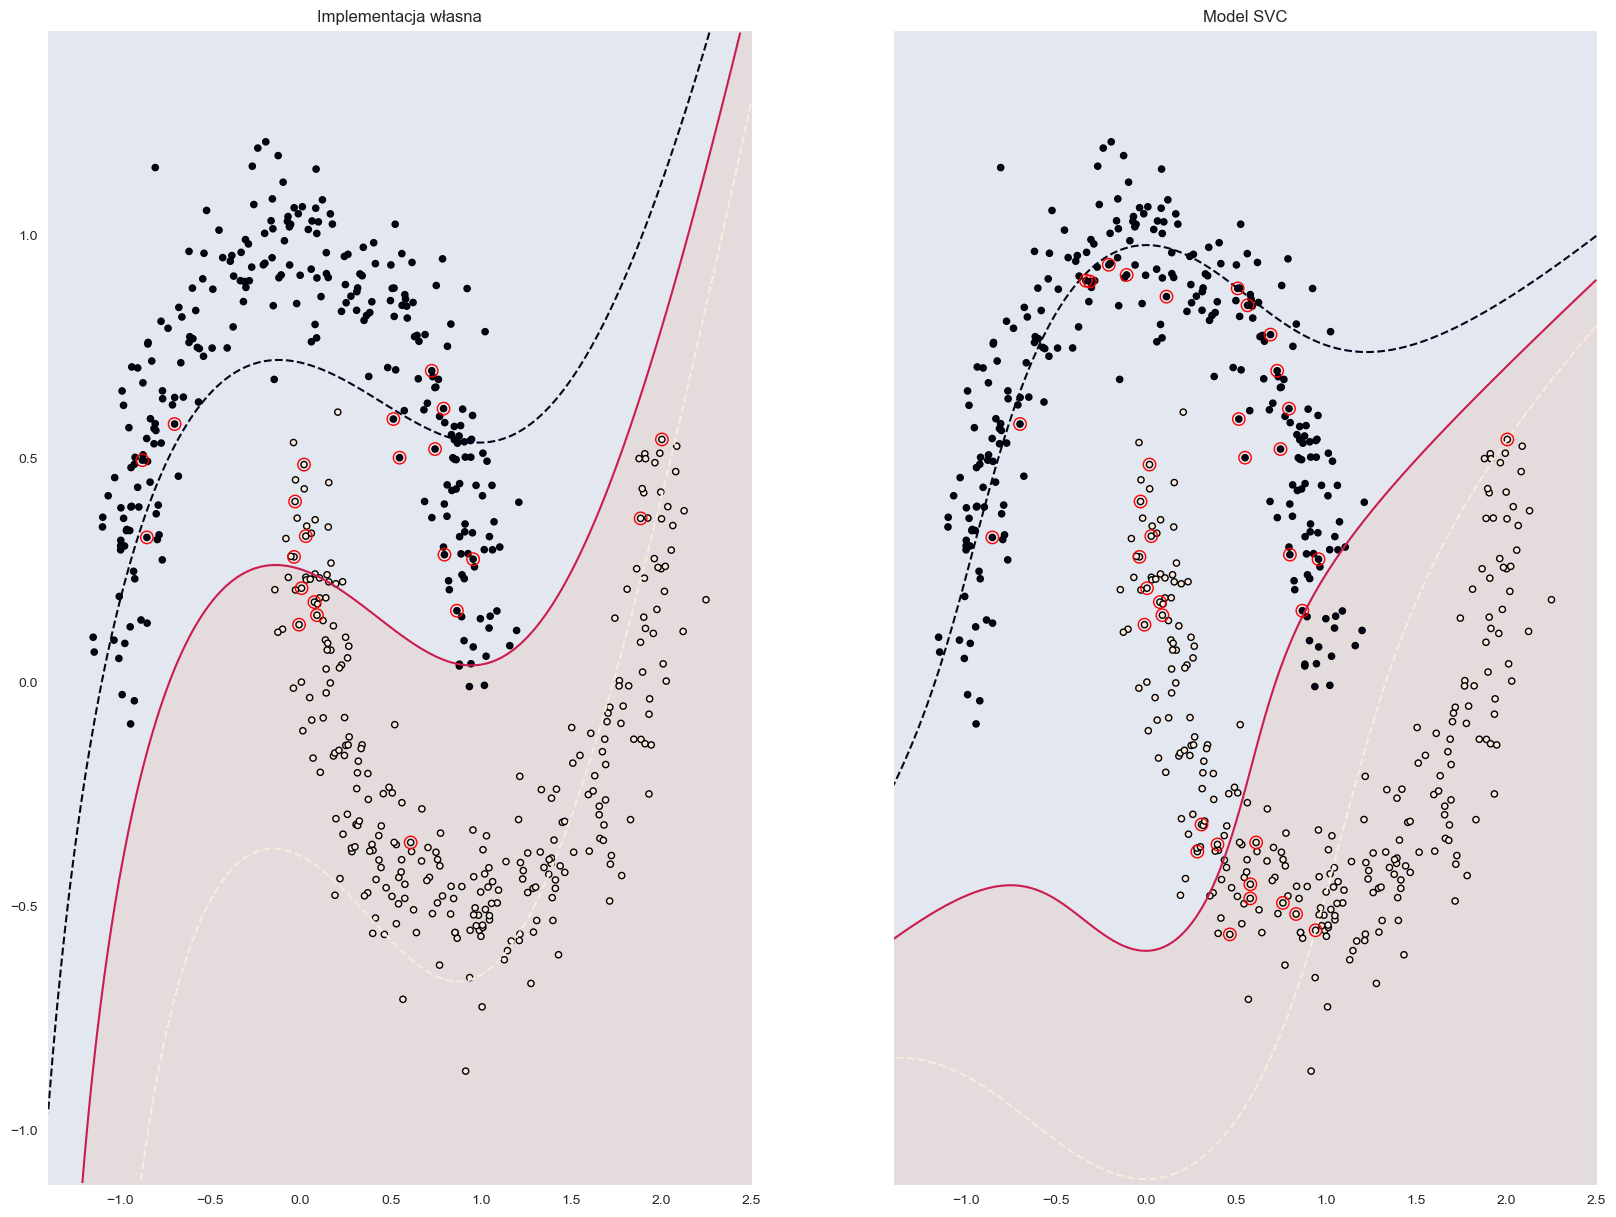

Model własny: Czulość: 0.9259259259259259, swoistość: 0.9876543209876543, Adjusted accuracy=0.9135802469135803
Model sklearn: Czulość: 0.654320987654321, swoistość: 0.934156378600823, Adjusted accuracy=0.5884773662551441


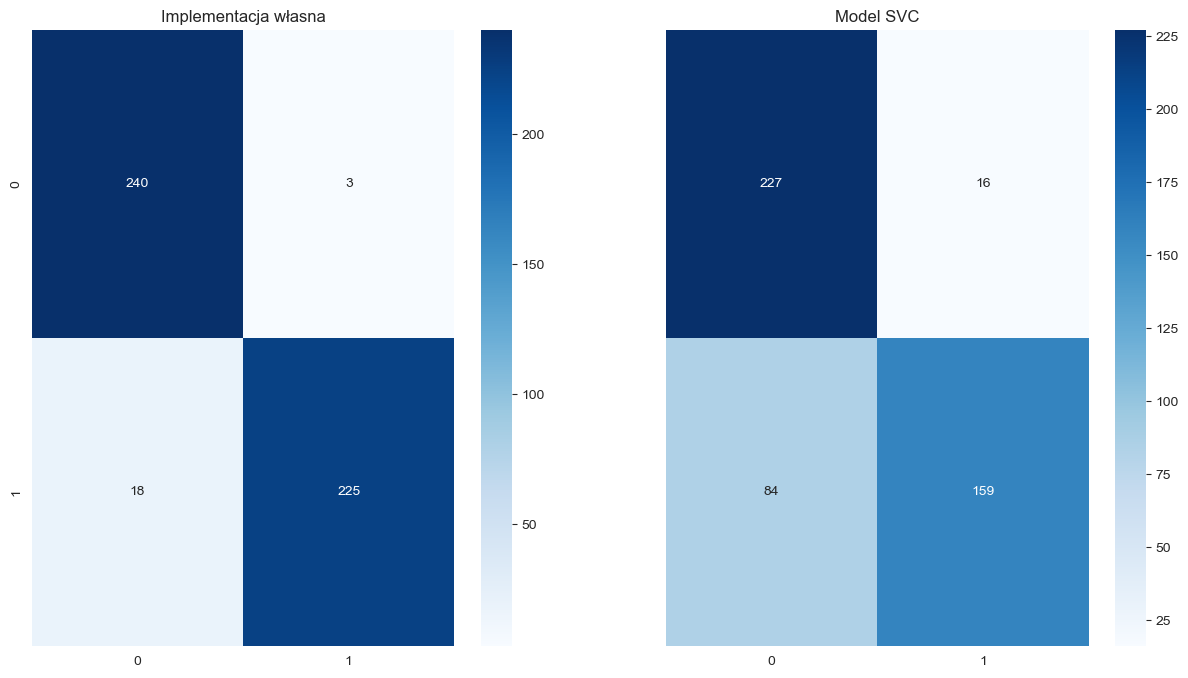

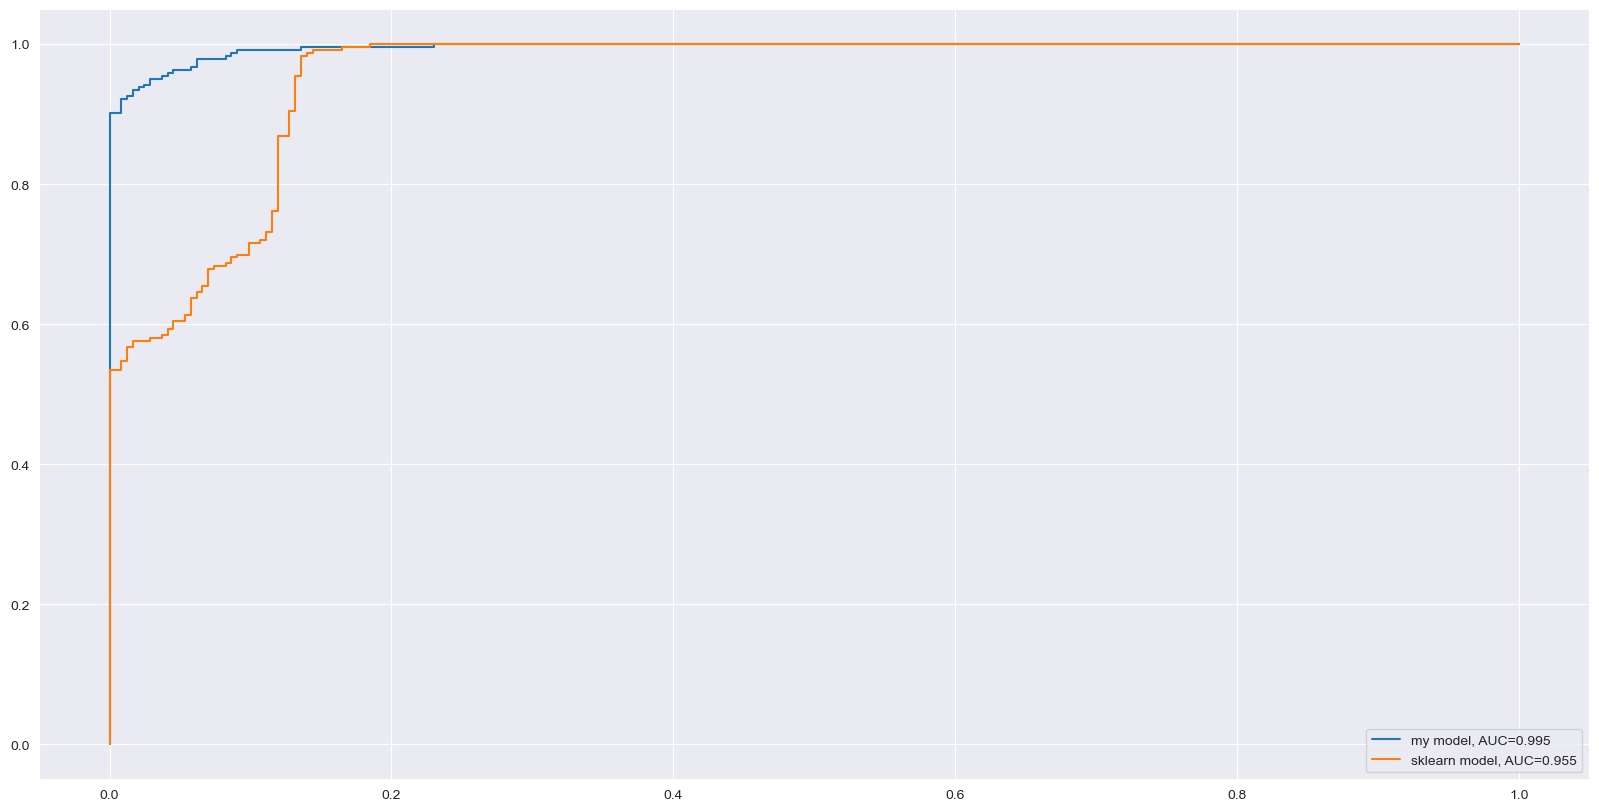

In [14]:
compare_models(my_model_poly, sk_model_poly, data_moons)

In [15]:
start = time()
for _ in range(n_trains):
    my_model_rbf = MyFuzzySVM(C=1, kernel='rbf', gamma=0.75)
    my_model_rbf.fit(data_moons.small_x_train, data_moons.small_fuzz_y_train)
print(f'Average training time: {(time() - start)/n_trains}s')

Average training time: 56.15851306915283s


In [16]:
start = time()
for _ in range(n_trains):
    sk_model_rbf = SVC(C=1, kernel='rbf', gamma=0.75)
    sk_model_rbf.fit(data_moons.small_x_train, data_moons.small_y_train)
print(f'Average training time: {(time() - start)/n_trains}s')

Average training time: 0.0009775161743164062s


C:\Users\DonChaka\.conda\envs\py39\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


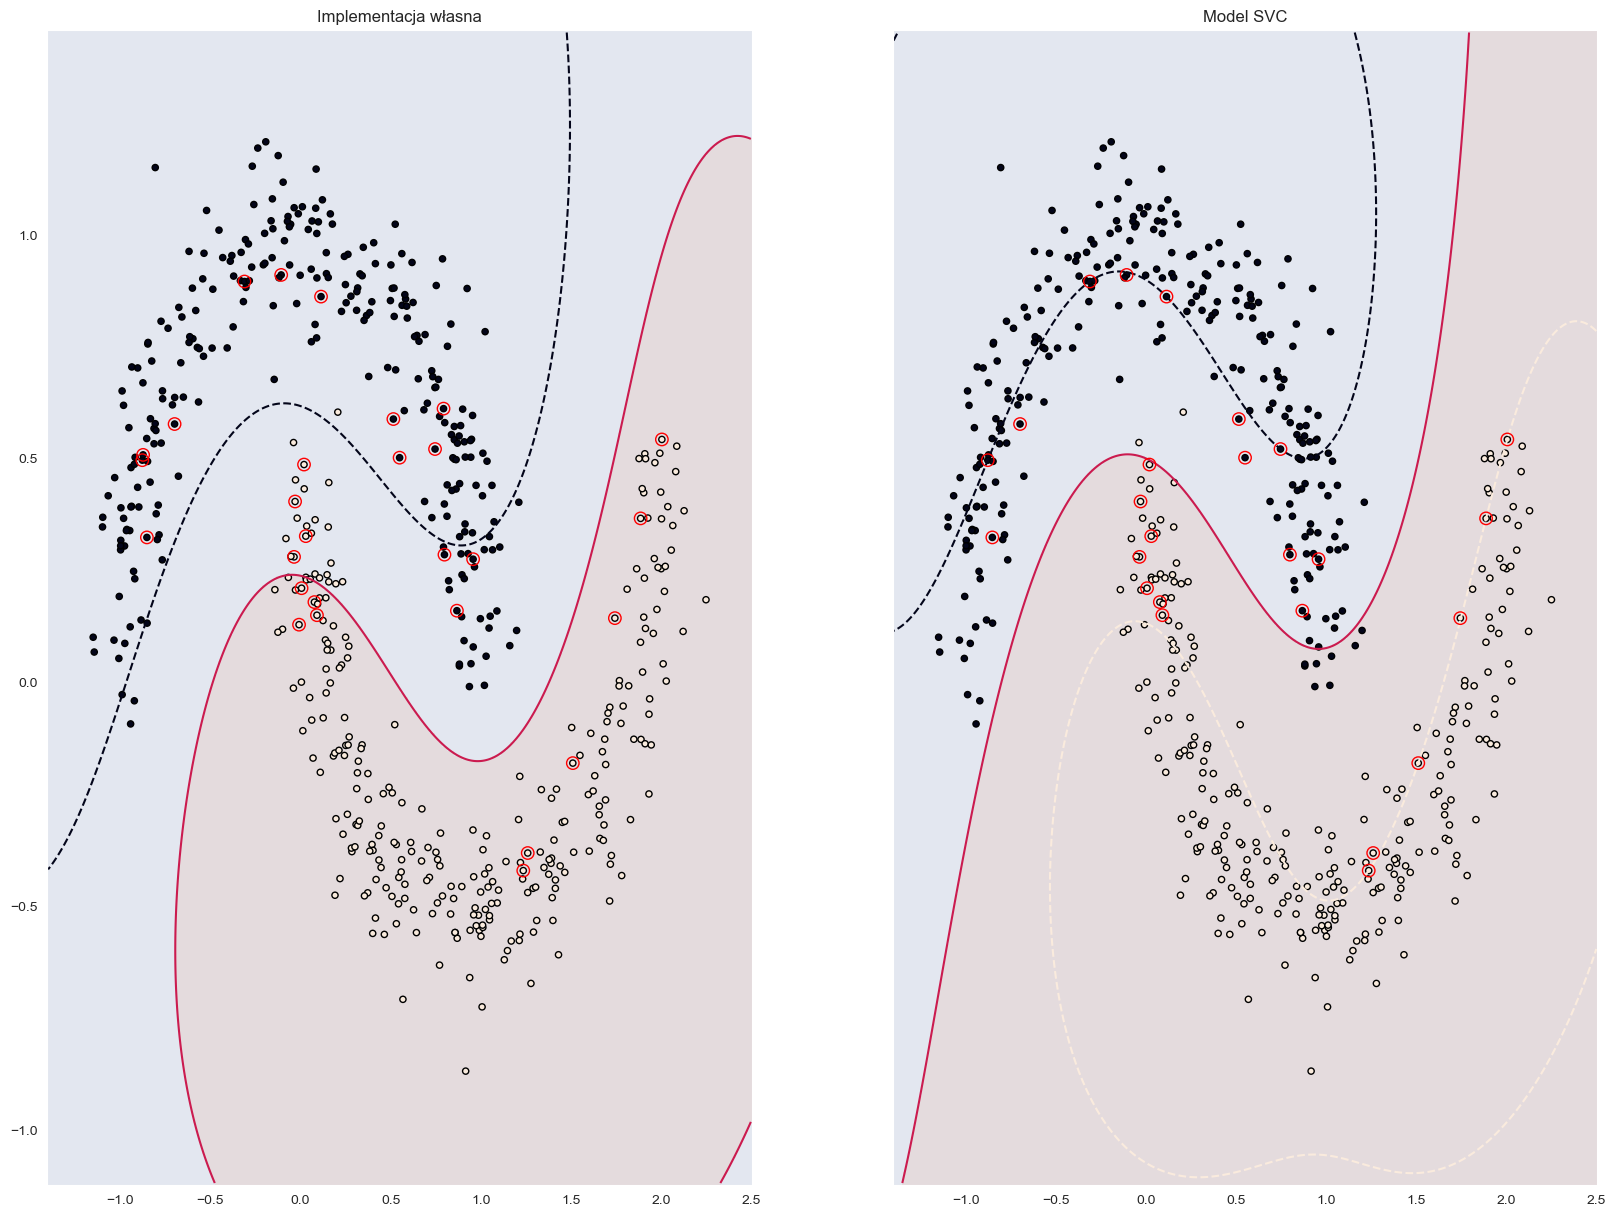

Model własny: Czulość: 0.9176954732510288, swoistość: 1.0, Adjusted accuracy=0.9176954732510287
Model sklearn: Czulość: 0.9917695473251029, swoistość: 0.9670781893004116, Adjusted accuracy=0.9588477366255144


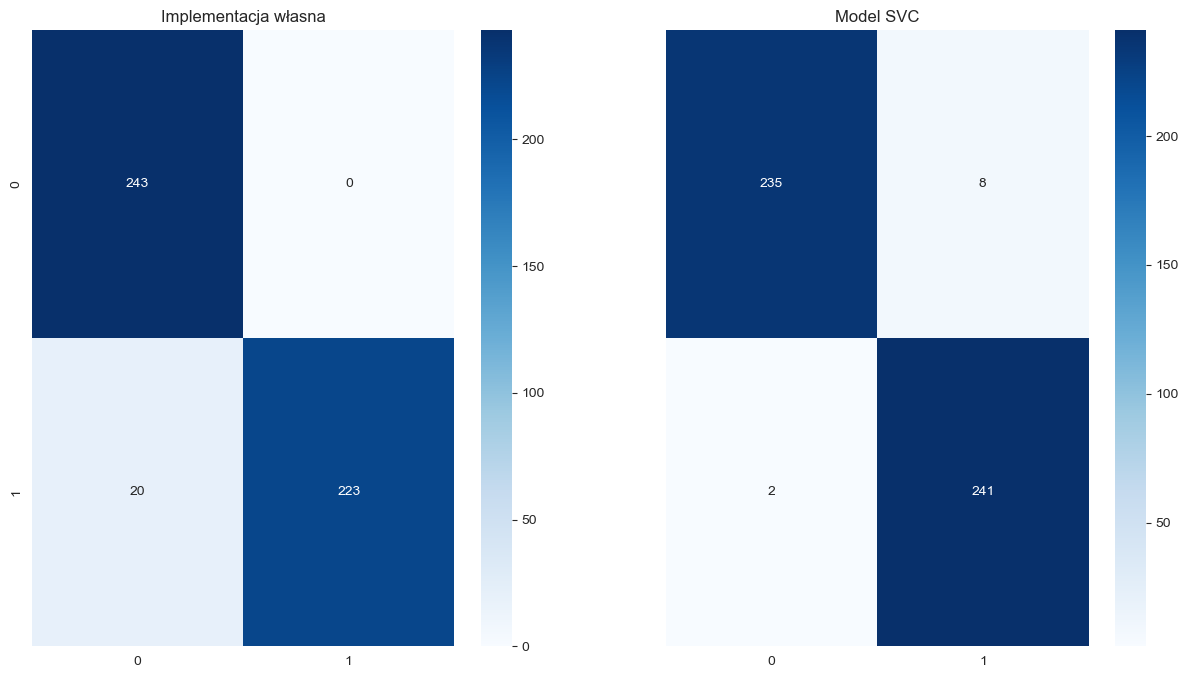

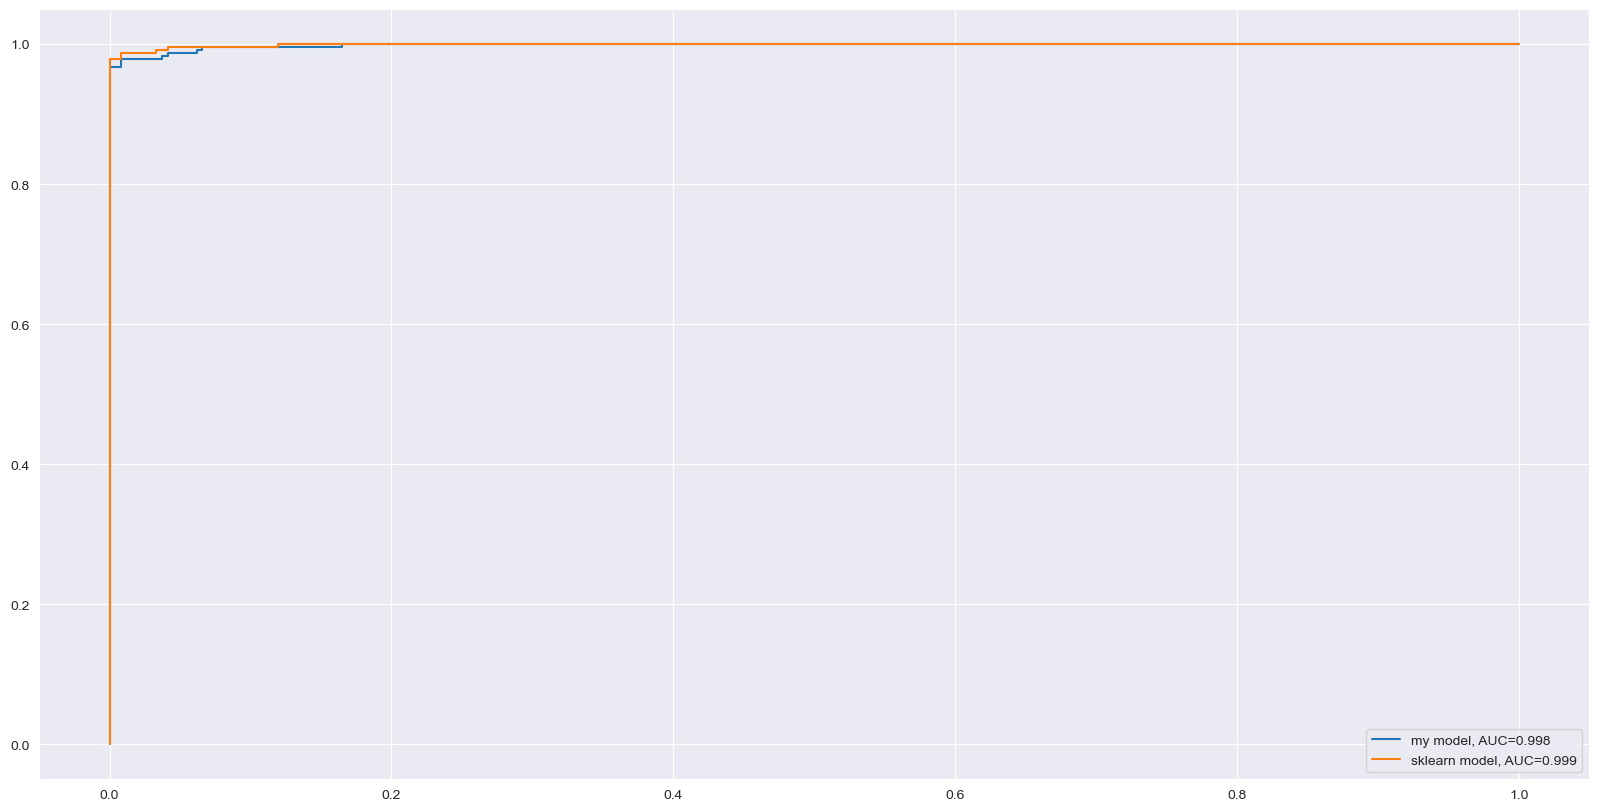

In [17]:
compare_models(my_model_rbf, sk_model_rbf, data_moons)